# A benchmark Pairs Trading strategy 

This notebook explores a pairs trading strategy using bollinger bands. This projected is being developed as part of a master thesis for the degree of Electrical and Computer Engineering.

**Author:** Simão Moraes Sarmento <br /> 
**Contact:** simaosarmento@hotmail.com

## Dependencies

This notebook requires code from:

Python files:
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

Pickle files:
- pickle file containing pairs to be traded (obtained from running `PairsTrading_CommodityETFs-Clustering.ipynb`)

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples, rather than coding the strategies theirselves. Please look into the files menitoned above for more detailed info on how the functions are built.

### Import Libraries

In [220]:
import numpy as np
import pandas as pd
import pickle

import json

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import alpha vantage
from alpha_vantage.timeseries import TimeSeries

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

# just set the seed for the random number generator
np.random.seed(107)

### Import Configurations

In [221]:
config_file = 'config/config_commodities_2010_2019.json'

In [222]:
with open(config_file, 'r') as f:
    config = json.load(f)

In [223]:
with open(config['dataset']['ticker_segment_dict'], 'rb') as handle:
    ticker_segment_dict = pickle.load(handle)

### Import Classes

In [224]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [225]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()

# Retrieve prices data set

We start by retrieving the data from a Dataframe saved in a pickle file, as it was previously processed in the `PairsTrading_CommodityETFS_Datapreprocessing.ipynb` notebook.

In [226]:
# intraday
#df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_intraday')

# inter day
df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_interpolated_screened')

In [227]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            ('01-01-2009',
                                                             '31-12-2017'),
                                                            ('01-01-2018',
                                                             '31-12-2018'),
                                                            remove_nan=True)

Total of 199 tickers
Total of 62 tickers after removing tickers with Nan values


In [228]:
len(df_prices_train)+len(df_prices_test)

2516

# Load Pairs

In [229]:
#with open('data/etfs/pickle/pairs_unfiltered.pickle', 'rb') as handle:
#    pairs = pickle.load(handle)

with open('data/etfs/pickle/pairs_category.pickle', 'rb') as handle:
    pairs = pickle.load(handle)

#with open('data/etfs/pickle/pairs_unsupervised_learning.pickle', 'rb') as handle:
#    pairs = pickle.load(handle)

In [230]:
lookback_multiplier= config['trading']['lookback_multiplier']
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
# obtain trading filter info
if config['trading_filter']['active'] == 1:
    trading_filter = config['trading_filter']
else:
    trading_filter = None

In [231]:
# intraday
#n_years_train = round(len(df_prices_train)/(240*78))

# interday
n_years_train = round(len(df_prices_train)/(240))

n_years_train

9

# Apply trading strategies

**Applying the Kalman filter based strategy**

In [257]:
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
train_results_without_costs, train_results_with_costs, performance_kalman = trader.apply_kalman_strategy(pairs, 
                                                                                             2,#entry_multiplier,
                                                                                             0.5,#exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=False,
                                                                                             rebalance=False)

Pair: 1/29
Pair: 2/29
Pair: 3/29
Pair: 4/29
Pair: 5/29
Pair: 6/29
Pair: 7/29
Pair: 8/29
Pair: 9/29
Pair: 10/29
Pair: 11/29
Pair: 12/29
Pair: 13/29
Pair: 14/29
Pair: 15/29
Pair: 16/29
Pair: 17/29
Pair: 18/29
Pair: 19/29
Pair: 20/29
Pair: 21/29
Pair: 22/29
Pair: 23/29
Pair: 24/29
Pair: 25/29
Pair: 26/29
Pair: 27/29
Pair: 28/29
Pair: 29/29


In [258]:
sharpe_results_kalman_nocosts, cum_returns_kalman_nocosts = train_results_without_costs
sharpe_results_kalman_w_costs, cum_returns_kalman_w_costs = train_results_with_costs

In [259]:
avg_sharpe_kalman, total_roi_kalman, anual_roi_kalman, positive_pct_kalman = \
    trader.calculate_metrics(sharpe_results_kalman_nocosts, cum_returns_kalman_nocosts, n_years_train)

Average result:  -0.029923455759314266
avg_annual_roi:  -2.9300562281907028
53.57142857142857 % of the pairs had positive returns


In [260]:
# WARNING: MUST CHANGE SHARPE RATIO
sharpe_results_kalman_w_costs = sharpe_results_kalman_nocosts
avg_sharpe_kalman, total_roi_kalman, anual_roi_kalman, positive_pct_kalman = \
    trader.calculate_metrics(sharpe_results_kalman_w_costs, cum_returns_kalman_w_costs, n_years_train)

Average result:  -0.029923455759314266
avg_annual_roi:  -15.386923102053562
53.57142857142857 % of the pairs had positive returns


Sharpe Ratio Distribution: 


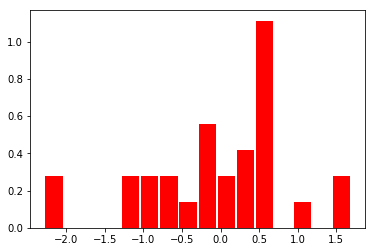

In [261]:
print('Sharpe Ratio Distribution: ')
n, bins, patches = plt.hist(sharpe_results_kalman_nocosts, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')

In [262]:
results_training, pairs_summary_training = trader.summarize_results(sharpe_results_kalman_nocosts,
                                                                    cum_returns_kalman_nocosts,
                                                                    performance_kalman,
                                                                    pairs,
                                                                    ticker_segment_dict, n_years_train)

Average result:  -0.029923455759314266
avg_annual_roi:  -2.9300562281907028
53.57142857142857 % of the pairs had positive returns


# Out of Sample Analysis

In this section, we analyze the performance of the strategy in the validation dataset. 

We proceed with some data exploration analysis. For this purpose we will do the following:

- Analyze which percentage of the identified pairs are still cointegrated in the validation period.
- Analyze which percentage of pairs have positive returns, and how many of those are still cointegrated.
- Analyze how many new pais were not identified to be cointegrated up to the validation period.
- Run strategy for identified pairs in training period.

This analysis will help us getting some insight into how the cointegrated pairs vary from time to time, and therefore how we should allocate our resources to predict when pairs are not cointegrated anymore.

## Applying the Strategy out-of Sample

We might want to apply the strategy in all pairs identified. Or, instead, we might prefer to apply the strategy only on those pairs that turned out to be profitable. Let's compare how both approaches work:

In [263]:
# intraday
#n_years_test = round(len(df_prices_test)/(240*78))

# interday
n_years_test = round(len(df_prices_test)/(240))

n_years_test

1

### Approach 1: Keeping every pair

**Kalman Out-of-Sample**

In [313]:
results_without_costs, results_with_costs, performance_kalman_test = trader.apply_kalman_strategy(pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=True,
                                                                                             rebalance=False)
sharpe_results_kalman_test_nocosts, cum_returns_kalman_test_nocosts = results_without_costs
sharpe_results_kalman_test_w_costs, cum_returns_kalman_test_w_costs = results_with_costs

Pair: 1/29
Pair: 2/29
Pair: 3/29
Pair: 4/29
Pair: 5/29
Pair: 6/29
Pair: 7/29
Pair: 8/29
Pair: 9/29
Pair: 10/29
Pair: 11/29
Pair: 12/29
Pair: 13/29
Pair: 14/29
Pair: 15/29
Pair: 16/29
Pair: 17/29
Pair: 18/29
Pair: 19/29
Pair: 20/29
Pair: 21/29
Pair: 22/29
Pair: 23/29
Pair: 24/29
Pair: 25/29
Pair: 26/29
Pair: 27/29
Pair: 28/29
Pair: 29/29


In [314]:
avg_sharpe_kalman_test, total_roi_kalman_test, anual_roi_kalman_test, positive_pct_kalman_test = \
    trader.calculate_metrics(sharpe_results_kalman_test_nocosts, cum_returns_kalman_test_nocosts, n_years_test)

Average result:  0.7851305232509563
avg_annual_roi:  30.915373562915562
86.20689655172414 % of the pairs had positive returns


In [315]:
# WARNING: MUST CHANGE SHARPE RATIO
sharpe_results_kalman_test_w_costs = sharpe_results_kalman_test_nocosts
avg_sharpe_kalman_test, total_roi_kalman_test, anual_roi_kalman_test, positive_pct_kalman_test = \
    trader.calculate_metrics(sharpe_results_kalman_test_w_costs, cum_returns_kalman_test_w_costs, n_years_test)

Average result:  0.7851305232509563
avg_annual_roi:  -22.795222083110144
86.20689655172414 % of the pairs had positive returns


In [316]:
avg_sharpe_kalman_test, total_roi_kalman_test, anual_roi_kalman_test, positive_pct_kalman_test = \
        trader.calculate_metrics(sharpe_results_kalman_test_nocosts, cum_returns_kalman_test_nocosts, n_years_test)

Average result:  0.7851305232509563
avg_annual_roi:  30.915373562915562
86.20689655172414 % of the pairs had positive returns


### Approach 2: Keeping only pairs that had positive returns in the training period

**Kalman Strategy**

In [317]:
sharpe_results_kalman_w_costs = np.asarray(sharpe_results_kalman_w_costs)
profitable_pairs_indices = np.argwhere(sharpe_results_kalman_w_costs > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]

In [324]:
results_without_costs, results_with_costs, performance_kalman_test = trader.apply_kalman_strategy(\
                                                                                             profitable_pairs, 
                                                                                             2,#entry_multiplier,
                                                                                             0.5,#exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=True,
                                                                                             rebalance=False)

Pair: 1/15
Pair: 2/15
Pair: 3/15
Pair: 4/15
Pair: 5/15
Pair: 6/15
Pair: 7/15
Pair: 8/15
Pair: 9/15
Pair: 10/15
Pair: 11/15
Pair: 12/15
Pair: 13/15
Pair: 14/15
Pair: 15/15


In [325]:
sharpe_results_kalman_test_nocosts, cum_returns_kalman_test_nocosts = results_without_costs
sharpe_results_kalman_test_w_costs, cum_returns_kalman_test_w_costs = results_with_costs

No costs:

In [326]:
avg_sharpe_kalman_test, total_roi_kalman_test, anual_roi_kalman_test, positive_pct_kalman_test = \
    trader.calculate_metrics(sharpe_results_kalman_test_nocosts, cum_returns_kalman_test_nocosts, n_years_test)

Average result:  0.3916998663826987
avg_annual_roi:  5.363962498856378
60.0 % of the pairs had positive returns


With costs:

In [327]:
# WARNING: MSUT CHANGE SHARPE RATIO
sharpe_results_kalman_test_w_costs = sharpe_results_kalman_test_nocosts
avg_sharpe_kalman_test, total_roi_kalman_test, anual_roi_kalman_test, positive_pct_kalman_test = \
    trader.calculate_metrics(sharpe_results_kalman_test_w_costs, cum_returns_kalman_test_w_costs, n_years_test)

Average result:  0.3916998663826987
avg_annual_roi:  -25.248488837562476
60.0 % of the pairs had positive returns


We can conclude that the 2nd approach presents better results. From now on, we assume the 2nd approach was taken.

# Validate the results

In [322]:
results, pairs_summary = trader.summarize_results(sharpe_results_kalman_test_w_costs,
                                                  cum_returns_kalman_test_w_costs,
                                                  performance_kalman_test, profitable_pairs, ticker_segment_dict,
                                                  n_years_test)

Average result:  0.39250090676680677
avg_annual_roi:  -25.248488837562476
60.0 % of the pairs had positive returns


In [300]:
pairs_summary.head()

,Leg1,Leg1_Segmt,Leg2,Leg2_Segmt,t_statistic,p_value,zero_cross,half_life,hurst_exponent,positive_trades,negative_trades,sharpe_result,positive_trades_per_pair_pct
0,RJN,Commodities: Energy,USL,Commodities: Energy Crude Oil,-4.241627,0.000560,121,34,0.434399,56,24,3.223667,70.000000
1,IEZ,Equity: U.S. Oil & Gas Equipment & Services,XOP,Equity: U.S. Oil & Gas Exploration & Production,-4.067478,0.001096,124,43,0.374766,3,1,1.381385,75.000000
2,DBO,Commodities: Energy Crude Oil,FCG,Equity: U.S. Natural Gas,-3.971335,0.001568,126,50,0.376579,38,29,1.130902,56.716418
3,IEZ,Equity: U.S. Oil & Gas Equipment & Services,SCO,Inverse Commodities: Energy Crude Oil,-3.972019,0.001564,93,49,0.369537,47,24,0.862351,66.197183
4,IYE,Equity: U.S. Energy,PXI,Equity: U.S. Energy,-3.696545,0.004162,128,39,0.396602,1,1,0.851056,50.000000


In [ ]:
adapted_cum_ret_total = []
for index in range(len(profitable_pairs)):
    _, adapted_cum_ret = trader.calculate_returns_adapted(
                                        y=performance_kalman_test[index][0][2]['Y_test'],
                                        x=performance_kalman_test[index][0][2]['X_test'],
                                        beta=performance_kalman_test[index][1]['beta'],
                                        positions=performance_kalman_test[index][1]['current_position'])
    adapted_cum_ret_total.append(adapted_cum_ret[-1]*100)

In [ ]:
adapted_cum_ret_total

In [ ]:
pd.Series(adapted_cum_ret_total).hist()

**Transaction costs**

In [190]:
for i in range(len(profitable_pairs)):
    print(performance_kalman_test[i][1][performance_kalman_test[i][1].ret != 0].ret.mean())

0.0012009821101279506
-0.0014815255323729639
0.0013084223332650296
0.005675987898940393
0.001246774610564136
0.0011664430080722662
-0.0002351822386724612
-0.0005264111241788798
0.00038015172913675435
0.006550134119335703
0.0011968819105392938
-0.0014621919477046555
0.0037468443485450024
0.0024592041055262405
0.005498101183878015
-0.002438208074343173
nan


**Controlling for range of returns**

In [ ]:
print('Maximum return obtained in a single trade, per pair')
for i in range(len(profitable_pairs)):
    print(performance_kalman_test[i][1]['position_return_(%)'].max())

In [ ]:
print('Worst return obtained in a single trade, per pair')
for i in range(len(profitable_pairs)):
    print(performance_kalman_test[i][1]['position_return_(%)'].min())

Tanto as returns máximas como as mínimas parecem ter valores dentro da normalidade.

## Training vs Validation

For a far comparison, we should compare the test resuls with the results obtained in the training set, but also using only the profitable pairs:

In [ ]:
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
sharpe_results_kalman, cum_returns_kalman, performance_kalman = trader.apply_kalman_strategy(profitable_pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=False)
avg_sharpe_kalman, total_roi_kalman, anual_roi_kalman, positive_pct_kalman = \
    trader.calculate_metrics(sharpe_results_kalman, cum_returns_kalman, n_years_train)

In [ ]:
print('The sharpe ratio obtained in the training set with the pairs used on the test set is ', avg_sharpe_kalman)
print('The sharpe ratio obtained in the test set is ', avg_sharpe_kalman_test)

As expected, the sharpe ratio is indeed higher in the training set.

In [ ]:
len(pairs)

In [ ]:
len(profitable_pairs)

## Analyzing Pairs' Overlap

There could be two possible interpretations for pairs' overlap.
1. We might be interested in checking which of the cointegrated pairs found in the training dataset are also cointegrated in the test set; Furthermore we want to explore how the two types of pairs perform.
2. We might be interested in finding if the pairs that would have been found in the test set by performing PCA + clustering would be cointegrated in the training set.

Starting with **1)**, let's see how many of the identified pairs actually turned out to be cointegrated during this period.

In [ ]:
pairs_overlapped, pairs_overlapped_index = series_analyser.pairs_overlap(pairs,
                                  config['pair_restrictions']['p_value_threshold'],
                                  config['pair_restrictions']['min_zero_crossings'],
                                  config['pair_restrictions']['min_half_life'],
                                  config['pair_restrictions']['hurst_threshold'])
print('{} of the {} pairs identified in the training set are also cointegrated in the test set'.format(\
    len(pairs_overlapped), len(pairs)))

In [ ]:
profitable_pairs_overlapped, profitable_pairs_overlapped_index = series_analyser.pairs_overlap(profitable_pairs,
                                  config['pair_restrictions']['p_value_threshold'],
                                  config['pair_restrictions']['min_zero_crossings'],
                                  config['pair_restrictions']['min_half_life'],
                                  config['pair_restrictions']['hurst_threshold'])
print('{} of the {} pairs with positive returns identified in the training set are also cointegrated in the test set'.format(\
    len(profitable_pairs_overlapped), len(profitable_pairs)))

### Is cointegration really important?

To answer this question we will see how many of the still cointegrated pairs had positive and negative returns. We will then do the same for those pairs that were not cointegrated. 

If both are as likely to have positive and negative returns, then it means cointegration is not as important of a condition. On the other hand, if we verify that all pairs that are still cointegrated turned out to be profitable and those that are not anymore led to consistent negative returns, we can infer that cointegration is a very important predictor of future returns.

We also compare the average performance of the two groups two see the relevance of being cointegrated with respect to the sharpe ratio obtained.

*Still cointegrated*

In [ ]:
# distribution for pairs which were cointegrated in train and test
sharpe_results_pairs_overlapped = np.asarray([sharpe_results_kalman_test[index] for index \
                                              in profitable_pairs_overlapped_index])
cum_returns_pairs_overlapped = np.asarray([cum_returns_kalman_test[index] for index \
                                              in profitable_pairs_overlapped_index])

if len(sharpe_results_pairs_overlapped)>0:
    _,_,_,_ = trader.calculate_metrics(sharpe_results_pairs_overlapped, cum_returns_pairs_overlapped,
                                   n_years_test)
else:
    print('0% of the pairs cointegrated in the train are also cointegrated in the test set')

*Not cointegrated anymore*

In [ ]:
# distribution for pairs which were cointegrated in train but not in test
profitable_pairs_not_overlapped_index = [i for i in np.arange(0,len(profitable_pairs))\
                                         if i not in profitable_pairs_overlapped_index]

sharpe_results_pairs_not_overlapped = np.asarray([sharpe_results_kalman_test[index] for index \
                                              in profitable_pairs_not_overlapped_index])

cum_returns_pairs_not_overlapped = np.asarray([cum_returns_kalman_test[index] for index \
                                              in profitable_pairs_not_overlapped_index])

_,_,_,_ = trader.calculate_metrics(sharpe_results_pairs_not_overlapped, cum_returns_pairs_not_overlapped,
                                   n_years_test)

Answering to the first question we were concerned with, we verify that a cointegrated pair is indeed more likely to have a positive return. Furthermore, we can conclude from the results that being cointegrated implied that those pairs generated higher returns. 

**TO REVIEW:Conclusion**: The fact that a pair is not cointegrated anymore does not impact the results obained. In fact, we just concluded that betting solely on the cointegrated pairs would yield a worse result. Therefore, we should not spend much effort in detecting pairs that are no cointegrated anymore.

Following with point number **2)**, we proceed to analyze the performance of the pairs that woud have been identified in the testing period.

In [ ]:
initial_test_date = config['dataset']['testing_initial_date']
final_teste_date = config['dataset']['testing_final_date']

# Get returns for test period
df_returns_test = data_processor.get_return_series(df_prices_test)

# APPLY PCA and CLUSTERING
range_n_components = config['PCA']['N_COMPONENTS']
X_test, clustered_series_all_test, clustered_series_test, counts_test, clf_test = \
            series_analyser.clustering_for_optimal_PCA(range_n_components[0], range_n_components[1],
                                                       df_returns_test, config['clustering'])
# Find pairs
pairs_test, unique_tickers_test = series_analyser.get_candidate_pairs(\
                                            clustered_series=clustered_series_test,
                                            pricing_df_train=df_prices_test,
                                            pricing_df_test=df_prices_train,
                                            min_half_life=config['pair_restrictions']['min_half_life'],
                                            min_zero_crosings=config['pair_restrictions']['min_zero_crossings'],
                                            p_value_threshold=config['pair_restrictions']['p_value_threshold'],
                                            hurst_threshold=config['pair_restrictions']['hurst_threshold']
                                            )

# Finally, see overlap
pairs_overlapped, pairs_overlapped_index = series_analyser.pairs_overlap(pairs_test,
                                  config['pair_restrictions']['p_value_threshold'],
                                  config['pair_restrictions']['min_zero_crossings'],
                                  config['pair_restrictions']['min_half_life'],
                                  config['pair_restrictions']['hurst_threshold'])
print('{} of the {} pairs identified in the test set are also cointegrated in the training set'.format(\
    len(pairs_overlapped), len(pairs_test)))

Let's see if the pairs identified in the test period lead indeed to improved results:

In [ ]:
sharpe_results_kalman_test_newpairs, cum_returns_kalman_test_newpairs, performance_kalman_test_newpairs =\
    trader.apply_kalman_strategy(pairs_test, entry_multiplier,exit_multiplier,trading_filter, test_mode=False)

_,_,_,_ = trader.calculate_metrics(sharpe_results_kalman_test_newpairs, cum_returns_kalman_test_newpairs,
                                   n_years_test)

The sharpe ratio is higher in this scenatio. Note hoewever, that the annual ROI is not so high as the pairs identified previously. This might be linked with the fact that these pairs did not prove to be cointegrated for a period as long as the other and therefore the pairs might be less stable.

## Analyzing the influence of pairs statistics

It's interesting to analyze whether we could have used extra information from the pairs trading statistic, instead of considering it just as a pass or not pass test. `Law 2017` explore this concept on their paper (htey basically rank pairs according to a trade off between t-statistic and spread deviation from its mean). However, what we see below is that there is no obvious influence of any parameter in the performance of the corresponding pair.

In [ ]:
pairs_summary.corr()[['sharpe_result', 'positive_trades_per_pair_pct']].loc[['t_statistic', 'p_value',
                                                                             'zero_cross', 'half_life',
                                                                             'hurst_exponent']]

### The Correlation Filter

The correlation filter aims to track how the correlation between the two legs of tha pair is varing, and provide that information as input to the trading strategy.

In [ ]:
example_pair = failed_pairs[2]

example_pair_leg1 = example_pair[0][0]
example_pair_leg2 = example_pair[0][1]

example_pair_prices = etfs_pricing[[example_pair_leg1, example_pair_leg2]]
example_pair_prices.plot(figsize=(15,5))


# proceed to calculate correlation
rolling_window = config['trading']['lookback_multiplier']*example_pair[0][2]['half_life']

# get returns
example_pair_returns = data_processor.get_return_series(example_pair_prices)

# analyze correlation on returns
example_correlation = example_pair_returns[example_pair_leg1].rolling(rolling_window).corr(example_pair_returns[example_pair_leg2])

# plot correlation of returns
diff_example_correlation = example_correlation.diff(periods=1)
#diff_example_correlation = diff_example_correlation*10
diff_example_correlation.plot()

This result indicates there's almost no correlation between correlation diff and returns... Let's see how this result varies on average:

In [ ]:
failure_correlations = []
for failure in failed_pairs:
    failure_df = failure[1][failure[1].units != 0]
    correlation = failure_df['ret'].corr(failure_df['correlation'])
    failure_correlations.append(correlation)
    
print(np.mean(failure_correlations))

However, we are not realyy interested in the correlation of the the diff column, but rather on the correlation with its sign.

In [ ]:
failure_correlations = []
for failure in failed_pairs:
    failure_df = failure[1][failure[1].units != 0]
    failure_df['diff_correlation_sign']=failure_df['diff_correlation'].apply(lambda row: -1 if row<0 else 1)
    correlation = failure_df['ret'].corr(failure_df['diff_correlation_sign'])
    failure_correlations.append(correlation)
    
print(np.mean(failure_correlations))

We could use mutual information rather than correlation as the sign is discrete. What about the relation with the zscore evolution?

### Analyze non-profitable pairs

In [ ]:
sharpe_results_kalman_test = np.asarray(sharpe_results_kalman_test)
negative_pairs_indices = np.argwhere(sharpe_results_kalman_test < 0)
print('{} out of {} pairs turned out to be non-profitable'.format(len(negative_pairs_indices), len(pairs)))

Let's get some more information on the non-profitable pairs:

In [ ]:
negative_pairs = [pairs[i] for i in negative_pairs_indices.flatten()]
negative_pairs = [(item[0], item[1]) for item in negative_pairs]
negative_pairs

To what clusters do these pairs belong?

In [ ]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    for pair in negative_pairs:
        if pair[0] in list(etfs_cluster_n.Ticker):
            print('Pair {} belongs to cluster {}'.format(pair, label_n))

How do the statistics rank?

In [ ]:
sorted_indices = np.flip(np.argsort(sharpe_results_bollinger), axis=0)

# initialize list of lists 
data = []
for index in sorted_indices:
    # get number of positive and negative positions
    position_returns = performance_bollinger[index][1].position_return
    positive_positions = len(position_returns[position_returns>0])
    negative_positions = len(position_returns[position_returns<0])
    data.append([pairs[index][0],
                 pairs[index][1],
                 pairs[index][2]['t_statistic'],
                 pairs[index][2]['p_value'],
                 pairs[index][2]['zero_cross'],
                 pairs[index][2]['half_life'],
                 pairs[index][2]['hurst_exponent'],
                 positive_positions,
                 negative_positions,
                 sharpe_results_bollinger[index]
                ])
      
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['Leg1', 'Leg2', 't_statistic', 'p_value', 'zero_cross',
                                   'half_life', 'hurst_exponent', 'positive trades', 'negative_trades',
                                   'sharpe_result']) 
df

In [ ]:
df.half_life.mean()

In [ ]:
# analyze correlations
print('Half-life vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['half_life']))
print('Zero crossings vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['zero_cross']))
print('p-value vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['p_value']))
print('t-statistic vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['t_statistic']))
print('Hurst exponent vs Sharpe Ratio correlation ', df['sharpe_result'].corr(df['hurst_exponent']))

Are there any signs these pairs were not profitable as the strategy evolves? Could we have predicted their lack of profitability?
- Using a ML algorithm that recognizes when a pair is not profitable anymore.
- Checking how the hurst exponent has been changing.
- Analyze their previous positions' returns